<a href="https://colab.research.google.com/github/aschnapp/SurvITE_Reproduce/blob/main/Synthetic_Data_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from numpy.random import choice

In [2]:
def sigmoid(x):
  """Converts real values to probabilities in [0,1]

  Args:
      x (float): input (real value or vector)

  Returns:
      float: sigmoid(x)
  """
  return 1 / (1 + np.exp(-x))

In [3]:
def draw_sample(haz_fn,censor_fn=None):
  """Samples a patient time point (tau with tilde in paper) which indicates min(T, C), i.e. time of event observed or time of censoring
  together with the corresponding delta binary variable which indicates whether an event was observed or not.

  Args:
      haz_fn (func): treatment specific hazard function
      censor_fn (func): censoring specific hazard function. Defaults to None.

  Returns:
      float, boolean: time point (tau with tilde in paper), delta
  """
  #set default
  t_sample = 30
  delta = 0

  #start with t=1 and go on till 30
  for t in range(1,31):
    #probability of hazard at t
    prob_t = haz_fn[t]  
    #probability of censor at t              
    if(censor_fn):                                          
      prob_t_censor = censor_fn[t]
    #random draw
    draw = np.random.uniform()

    #draw until either censor or hazard or neither occurs but not both
    while(censor_fn and draw<=prob_t and draw<=prob_t_censor):
      draw = np.random.uniform()

    #hazard occured
    if(draw<=prob_t):
      t_sample =t
      delta=1
      break 

    # censoring occured
    if(censor_fn and draw<=prob_t_censor):
      t_sample = t
      delta = 0
      break
  return t_sample,delta
    


In [4]:
def generate_X(n=10,rho=0.2,num_samples=5000):
  """Generates patient characteristic data multivariate normal distribution

  Args:
      n (int, optional): number of patient characteristic attributes. Defaults to 10.
      rho (float, optional): normal distribution specific parameter. Defaults to 0.2.
      num_samples (int, optional): number of patient to generate patient characterisic data for. Defaults to 5000.

  Returns:
      float[10D]: matrix of size (num_samples x n) patient characteristic data
  """
  # 1x10 matrix of zeros as means
  mean = np.zeros(n)
  cov =(1-rho)*np.eye(n) + rho * np.ones(n)*(np.ones(n).T)
  X = np.random.multivariate_normal(mean, cov, num_samples)
  return X


In [5]:
from re import T
#Ground truth hazard function

def lambda_function2(t_max, x, a):
  """Treatment specific hazard function which represents the probability distribution for a event to happen at time t (see paper section 6)

  Args:
      t_max (int): maximum value of time interval to investigate (in paper set to value: 30)
      x (float): patient characteristics
      a (boolean): treatment administered at baseline or not

  Returns:
      int{float}: dictionary with time points as key and probability as value 
  """
  haz_fn = {}
  haz_fn[0]=0
  for t in range(1,t_max):
      if t <= 10:
        haz_fn[t]= 0.1 * sigmoid(-5 * (x[0])**2 - a * (int(x[2] >= 0) + 0.5))
      else:
        haz_fn[t]= 0.1 * sigmoid(10 * x[1] - a * (int(x[2] >= 0) + 0.5))
  haz_fn[30]=0
  return haz_fn

def lambda_function_censoring(t_max, x):
  """ Hazard function which represents the probability distribution of censoring at time point t (see paper section 6)

  Args:
      t_max (int): maximum value of time interval to investigate (in paper set to value: 30)
      x (float): patient characteristics

  Returns:
      int{float}: dictionary with time points as key and probability as value 
  """
  haz_fn_censoring = {}
  for t in range(1,t_max):
    haz_fn_censoring[t] = 0.01 * sigmoid(10 * (x[3]**2))

  haz_fn_censoring[30] = 1

  return haz_fn_censoring

def alpha(P, X, zeta):
  """Generates treatment binary variable data as described in 'Synthetic Experiments' in the paper

  Args:
      P (int): treatment selection variables (allowing covariate set overlap or not)
      X (float): patient characteristic
      zeta (int): selection strength

  Returns:
      boolean[]: treatment boolean data 
  """
  a = []
  for x in X:
    prob = zeta * sigmoid(x[P[0]] + x[P[1]])
    prob = min(prob,1)
    alpha = np.random.binomial(p=prob, size=(1), n=1)
    a.append(alpha)
  return np.array(a)

In [13]:
def generate_data(P=[0,1] , zeta=3, is_censor=False,t_max=30):
  """Generates synthetic  data
     zeta: Treatment selection strength, higher zeta would mean more patients would have treatment administered to them
     P: covariates that effect treatment administration

     is_censor: should scenario involve censoring
     t_max: time period of study after which there is automatic censoring
  
  Returns:
      (float[], boolean[], int[], boolean[]): patient characteristics, treatment assignment, time point to event, and delta (event was observed or not) for all patients.
  """
  cens=None

  #Generate synthetic patient data
  X = generate_X()

  # Generate treatment administration based on zeta and P
  A = alpha(P, X, zeta)

  
  time_to_event = []
  delta = []
  hazs = []

  #For each patient 
  for x,a in zip(X,A):
    # Get the hazard function given the input
    haz = lambda_function2(t_max , x, a)
    hazs.append(haz)

    #If consoring needed for scenario
    if(is_censor):
      cens = lambda_function_censoring(t_max,x)

    #Generate the time to event(t) and censored(d) given hazard function
    t,d = draw_sample(haz,cens)
    time_to_event.append(t)
    delta.append(d)
  return(hazs, X,A,time_to_event,delta)


#Numpy savable format of hazard function
def np_haz_fun(data):
  hazs_fn = np.zeros((5000, 31)) 
  for i, data_point in enumerate(data):
    hazs_fn[i] = np.array(list(data_point.values()))
  return


In [23]:
#S1 synthetic data

# def generate_s1_data():
#   """Generates S1 synthetic simulation data which means no treatment and no censoring is applied.
  
#   Returns:
#       (float[], int[], boolean[]): patient characteristics, time point to event, and delta (event was observed or not) for all patients.
#   """
#   X = generate_X()
#   time_to_event = []
#   delta = []
#   hazs = []
#   for x in X:
#     # Get the hazard function given the input
#     haz = lambda_function2(30 , x, 0)

#     # Generate the event given hazard function
#     t,d = draw_sample(haz)
#     time_to_event.append(t)
#     delta.append(d)
#     hazs.append(haz)
#   return(hazs, X, time_to_event, delta)

# We set a (treatment) variable to 0 for all patients in both training and test data as treatment is not applied in this setting

# Generate S1 Data
haz_train, X_train, A_train, t_train,d_train = generate_data(zeta=0,is_censor=False)
haz_test, X_test, A_test, t_test,d_test = generate_data(zeta=0,is_censor=False)


#S1 training dataset
S_1_train = {
    'x':X_train,
    't':np.array(t_train),
    'a':A_train,
    'y':np.array(d_train),
    'haz': np_haz_fun(haz_train)
}

#S1 testing dataset
S_1_test = {
    'x':X_test,
    't':np.array(t_test),
    'a':A_test,
    'y':np.array(d_test),
    'haz': np_haz_fun(haz_test)
}


<ipython-input-13-173c97b4691a>:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hazs_fn[i] = np.array(list(data_point.values()))


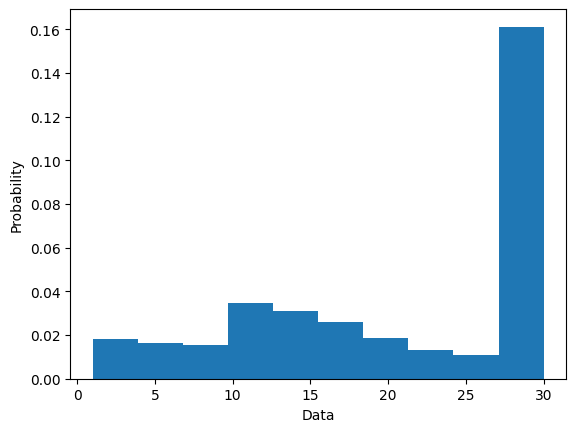

In [24]:
import matplotlib.pyplot as plt
plt.hist(S_1_train['t'], density=True,)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

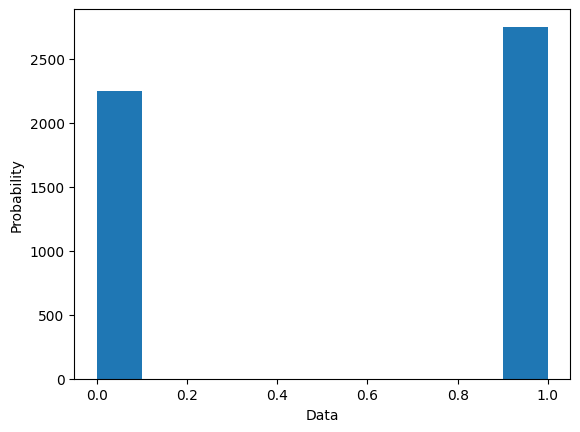

In [25]:
import matplotlib.pyplot as plt
plt.hist(S_1_train['y'])  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

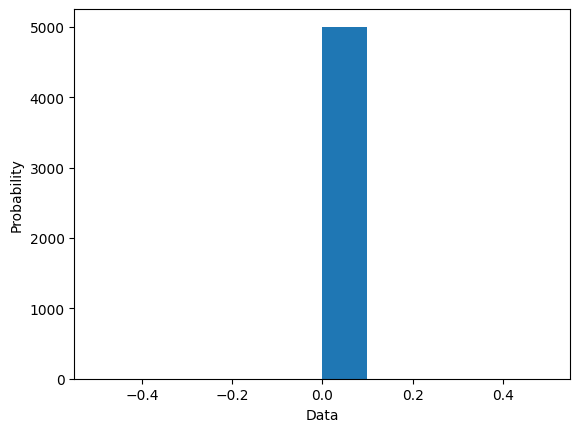

In [26]:
import matplotlib.pyplot as plt
plt.hist(S_1_train['a'])  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

In [27]:
#S2 synthetic data
# def generate_s2_data():
#   """Generates S2 synthetic simulation data which introduces informative censoring on top of S1 conditions.
  
#   Returns:
#       (float[], int[], boolean[]): patient characteristics, time point to event (event or censoring), and delta (event was observed or not) for all patients.
#   """
#   X = generate_X()
#   time_to_event = []
#   delta = []
#   hazs = []
#   for x in X:
#     # Get the hazard function given the input
#     haz = lambda_function2(30 , x, 0)
#     hazs.append(haz)
#     cens = lambda_function_censoring(30,x)

#     # Generate the event given hazard function
#     t,d = draw_sample(haz,cens)
#     time_to_event.append(t)
#     delta.append(d)
#   return(X,time_to_event,delta)

# Synthetic simulation data which introduces informative censoring on top of S1 conditions.
A = np.zeros(5000)

haz_train, X_train, A_train, t_train,d_train = generate_data(zeta=0,is_censor=True)
haz_test, X_test,A_test, t_test,d_test = generate_data(zeta=0,is_censor=True)


#S2 training dataset
S_2_train = {
    'x':X_train,
    't':np.array(t_train),
    'a':A_train,
    'y':np.array(d_train),
    'haz': np_haz_fun(haz_train)
}

#S1 testing dataset
S_2_test = {
    'x':X_test,
    't':np.array(t_test),
    'a':A_test,
    'y':np.array(d_test),
    'haz': np_haz_fun(haz_test)
}


<ipython-input-13-173c97b4691a>:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hazs_fn[i] = np.array(list(data_point.values()))


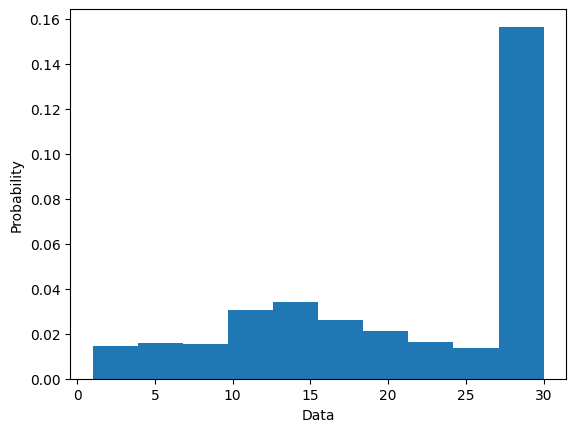

In [28]:
plt.hist(S_2_train['t'], density=True,)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

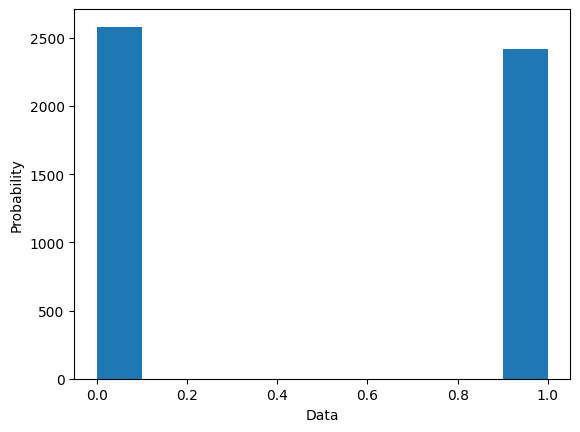

In [29]:
plt.hist(S_2_train['y'])  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

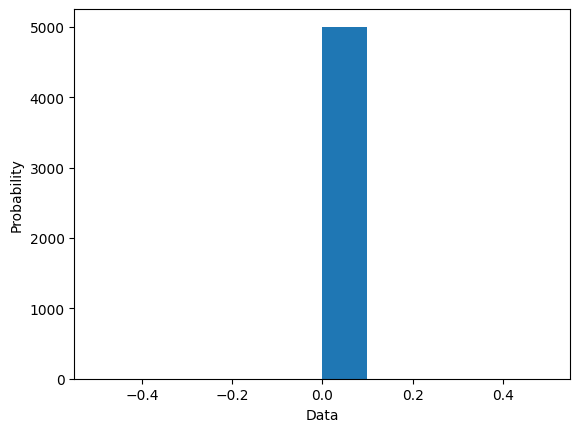

In [31]:
plt.hist(S_2_train['a'])  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

In [32]:
#S3 synthetic data, biased treatment no censoring
# As mentioned in the paper we set selection strength zeta=3 and P={1,2} ie full overlap of covariate set and event inducing covariates

# def generate_s3_data(is_censor=False):
#   """Generates S3 synthetic simulation data which introduces biased treatment assignment without censoring.
  
#   Returns:
#       (float[], boolean[], int[], boolean[]): patient characteristics, treatment assignment, time point to event, and delta (event was observed or not) for all patients.
#   """
#   P= [8,9]
#   zeta = 3
#   cens=None
#   X = generate_X()
#   A = alpha(P, X, zeta)
#   time_to_event = []
#   delta = []
#   for x,a in zip(X,A):
#     # Get the hazard function given the input
#     haz = lambda_function2(30 , x, a)
#     if(is_censor):
#       cens = lambda_function_censoring(30,x)

#     #Generate the event given hazard function
#     t,d = draw_sample(haz,cens)
#     time_to_event.append(t)
#     delta.append(d)
#   return(X,A,time_to_event,delta)


#S3 training dataset with without censoring but biased treatment assignment, 
# P={0,1} which is  covariate set overlaps with event inducing set
haz_train, X_train,A_train,t_train,d_train = generate_data(P=[0,1])
haz_test, X_test,A_test,t_test,d_test = generate_data(P=[0,1])



S_3_train_overlap = {
    'x':X_train,
    't':np.array(t_train),
    'a':A_train,
    'y':np.array(d_train),
    'haz': np_haz_fun(haz_train)
}

#S3 testing dataset
S_3_test_overlap = {
    'x':X_test,
    't':np.array(t_test),
    'a':A_test,
    'y':np.array(d_test),
    'haz': np_haz_fun(haz_test)
}

# P={8,9} which is  covariate set overlaps with event inducing set
haz_train, X_train,A_train,t_train,d_train = generate_data(P=[8,9])
haz_test, X_test,A_test,t_test,d_test = generate_data(P=[8,9])



S_3_train_nooverlap = {
    'x':X_train,
    't':np.array(t_train),
    'a':A_train,
    'y':np.array(d_train),
    'haz': np_haz_fun(haz_train)
}

#S3 testing dataset
S_3_test_nooverlap = {
    'x':X_test,
    't':np.array(t_test),
    'a':A_test,
    'y':np.array(d_test),
    'haz': np_haz_fun(haz_test)
}




<ipython-input-13-173c97b4691a>:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hazs_fn[i] = np.array(list(data_point.values()))


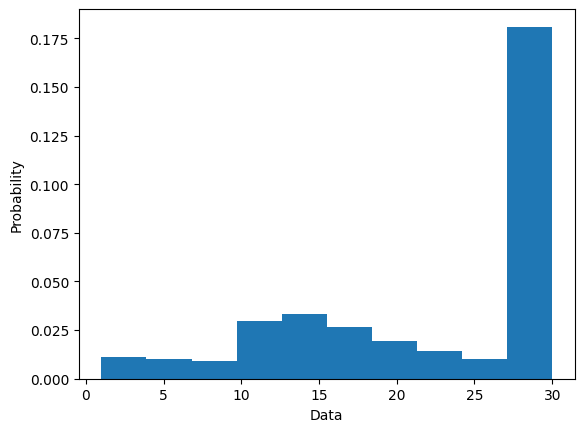

In [33]:
plt.hist(S_3_train_nooverlap['t'], density=True,)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

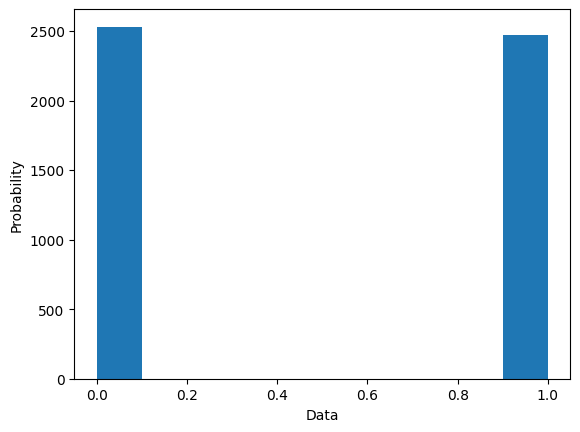

In [34]:
plt.hist(S_3_train_nooverlap['y'])  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

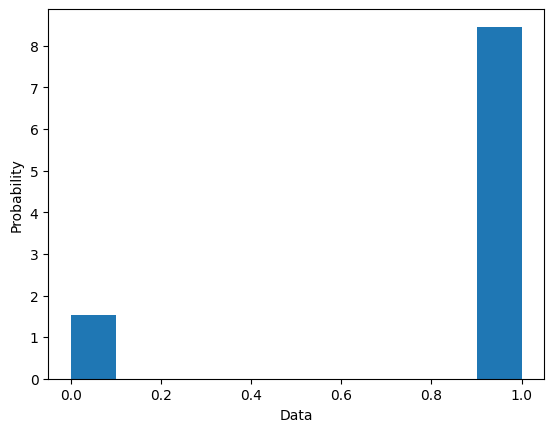

In [35]:
plt.hist(S_3_train_nooverlap['a'], density=True,)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

In [36]:
#S4 synthetic data, biased treatment and  censoring. S4 is just S3 with censoring and same parameters zeta and P

# P={0,1} which is  covariate set overlaps with event inducing set
haz_train, X_train,A_train,t_train,d_train = generate_data(P=[0,1],is_censor=True)
haz_test, X_test,A_test,t_test,d_test = generate_data(P=[0,1],is_censor=True)



S_4_train_overlap = {
    'x':X_train,
    't':np.array(t_train),
    'a':A_train,
    'y':np.array(d_train),
    'haz': np_haz_fun(haz_train)
}

#S3 testing dataset
S_4_test_overlap = {
    'x':X_test,
    't':np.array(t_test),
    'a':A_test,
    'y':np.array(d_test),
    'haz': np_haz_fun(haz_test)
}

# P={8,9} which is  covariate set overlaps with event inducing set
haz_train, X_train,A_train,t_train,d_train = generate_data(P=[8,9],is_censor=True)
haz_test, X_test,A_test,t_test,d_test = generate_data(P=[8,9],is_censor=True)



S_4_train_nooverlap = {
    'x':X_train,
    't':np.array(t_train),
    'a':A_train,
    'y':np.array(d_train),
    'haz': np_haz_fun(haz_train)
}

#S3 testing dataset
S_4_test_nooverlap = {
    'x':X_test,
    't':np.array(t_test),
    'a':A_test,
    'y':np.array(d_test),
    'haz': np_haz_fun(haz_test)
}


<ipython-input-13-173c97b4691a>:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hazs_fn[i] = np.array(list(data_point.values()))


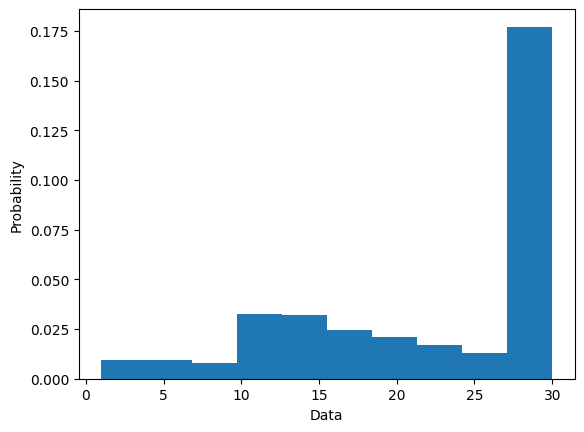

In [37]:
plt.hist(S_4_train_nooverlap['t'], density=True,)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

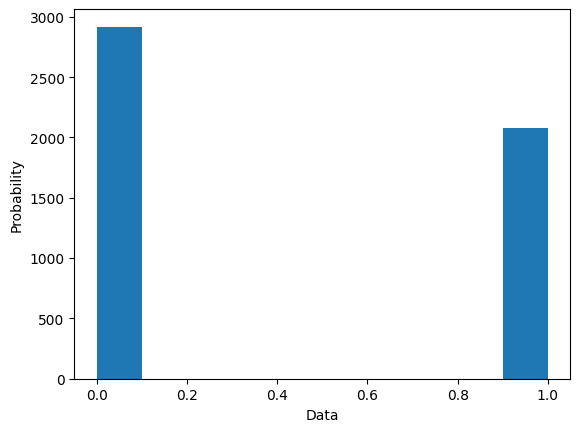

In [38]:
plt.hist(S_4_train_nooverlap['y'])  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

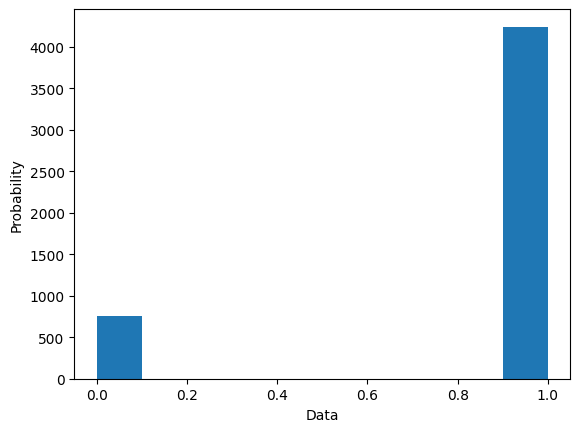

In [39]:
plt.hist(S_4_train_nooverlap['a'])  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

In [40]:
def save_data(file_path, data, haz_included=False):
  np.savez(file_path,x = data['x'],a = data['a'],t = data['t'],y = data['y'], haz = data['haz'])

In [41]:
#Save synthetic data

save_data('/content/data/S1/train.npz',S_1_train)
save_data('/content/data/S1/test.npz',S_1_test)
save_data('/content/data/S2/train.npz',S_2_train)
save_data('/content/data/S2/test.npz',S_2_test)
save_data('/content/data/S3/overlap/train.npz',S_3_train_overlap)
save_data('/content/data/S3/overlap/test.npz',S_3_test_overlap)
save_data('/content/data/S3/nooverlap/train.npz',S_3_train_nooverlap)
save_data('/content/data/S3/nooverlap/test.npz',S_3_test_nooverlap)
save_data('/content/data/S4/overlap/train.npz',S_4_train_overlap)
save_data('/content/data/S4/overlap/test.npz',S_4_test_overlap)
save_data('/content/data/S4/nooverlap/train.npz',S_4_train_nooverlap)
save_data('/content/data/S4/nooverlap/test.npz',S_4_test_nooverlap)




In [43]:
!zip -r ./data.zip /content/data

  adding: content/data/ (stored 0%)
  adding: content/data/S4/ (stored 0%)
  adding: content/data/S4/nooverlap/ (stored 0%)
  adding: content/data/S4/nooverlap/train.npz (deflated 25%)
  adding: content/data/S4/nooverlap/test.npz (deflated 25%)
  adding: content/data/S4/overlap/ (stored 0%)
  adding: content/data/S4/overlap/train.npz (deflated 25%)
  adding: content/data/S4/overlap/test.npz (deflated 25%)
  adding: content/data/S4/.ipynb_checkpoints/ (stored 0%)
  adding: content/data/S3/ (stored 0%)
  adding: content/data/S3/nooverlap/ (stored 0%)
  adding: content/data/S3/nooverlap/train.npz (deflated 25%)
  adding: content/data/S3/nooverlap/test.npz (deflated 25%)
  adding: content/data/S3/overlap/ (stored 0%)
  adding: content/data/S3/overlap/train.npz (deflated 25%)
  adding: content/data/S3/overlap/test.npz (deflated 25%)
  adding: content/data/S3/.ipynb_checkpoints/ (stored 0%)
  adding: content/data/.ipynb_checkpoints/ (stored 0%)
  adding: content/data/S1/ (stored 0%)
  adding